In [2]:
import argparse
import pickle
import torch
import os
import glob
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import pandas as pd
from pathlib import Path
from statistics import mean

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from beautifultable import BeautifulTable
from pathlib import Path
from incremental_rl.train import IncrementalExpt, set_one_thread
from sys import platform
if platform == "darwin":
    import matplotlib as mpl
    mpl.use("Qt5Agg")
    
from rl_suite.algo.mlp_policies import SquashedGaussianMLPActor
from rl_suite.misc.dm_reacher_comparisons import FixedTimeLimitReacher

    
# colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = dict(mcolors.BASE_COLORS, **mcolors.XKCD_COLORS)
colors = list(colors.keys())
colors.remove('w')

/home/vasan/src/rtrl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.1.2 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Set dimensions in the background of matplotlib. Call both functions for pretty plots :) 

def setsizes():
    plt.rcParams['axes.linewidth'] = 1.0
    plt.rcParams['lines.markeredgewidth'] = 1.0
    plt.rcParams['lines.markersize'] = 3

    plt.rcParams['xtick.labelsize'] = 14.0
    plt.rcParams['ytick.labelsize'] = 14.0
    plt.rcParams['xtick.direction'] = "out"
    plt.rcParams['ytick.direction'] = "in"
    plt.rcParams['lines.linewidth'] = 3.0
    plt.rcParams['ytick.minor.pad'] = 50.0

    # https://tex.stackexchange.com/questions/18687/how-to-generate-pdf-without-any-type3-fonts
    plt.rcParams['pdf.fonttype'] = 42   

def setaxes():
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.gcf().subplots_adjust(left=0.2)
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # ax.spines['left'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis='both', direction='out', which='minor', width=2, length=3,
                   labelsize=12, pad=8)
    ax.tick_params(axis='both', direction='out', which='major', width=2, length=8,
                   labelsize=12, pad=8)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    for tick in ax.xaxis.get_major_ticks():
        # tick.label.set_fontsize(getxticklabelsize())
        tick.label.set_fontsize(14)
    for tick in ax.yaxis.get_major_ticks():
        # tick.label.set_fontsize(getxticklabelsize())
        tick.label.set_fontsize(14)

def plt_formatter():
    setsizes()
    setaxes()

In [4]:
def smoothed_curve(returns, ep_lens, x_tick=5000, window_len=5000):
    """
    Args:
        returns: 1-D numpy array with episodic returs
        ep_lens: 1-D numpy array with episodic returs
        x_tick (int): Bin size
        window_len (int): Length of averaging window
    Returns:
        A numpy array
    """
    rets = []
    x = []
    cum_episode_lengths = np.cumsum(ep_lens)

    if cum_episode_lengths[-1] >= x_tick:
        y = cum_episode_lengths[-1] + 1
        steps_show = np.arange(x_tick, y, x_tick)

        for i in range(len(steps_show)):
            rets_in_window = returns[(cum_episode_lengths > max(0, x_tick * (i + 1) - window_len)) *
                                     (cum_episode_lengths < x_tick * (i + 1))]
            if rets_in_window.any():
                rets.append(np.mean(rets_in_window))
                x.append((i+1) * x_tick)

    return np.array(rets), np.array(x)

def human_format_numbers(num, use_float=False):
    # Make human readable short-forms for large numbers
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    if use_float:
        return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])
    return '%d%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])


def set_labels(title, xlabel="Timesteps", ylabel="Return", labelpad=25):
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    h = plt.ylabel(ylabel, fontsize=14, labelpad=labelpad)
    h.set_rotation(0)
    (ticks, texts) = plt.xticks()
    try:
        new_labels = [human_format_numbers(int(k.get_text())) for k in texts]
    except:
        new_labels = [human_format_numbers(int(k)) for k in ticks]
    plt.xticks(ticks=ticks, labels=new_labels)
    plt.grid()
    plt.tight_layout()

In [5]:
x_tick = 10000
window_len = 20000
df = pd.DataFrame(columns=["step", "avg_ret", "seed", "timeout"])
legend_elements = []

color_palette = {
    "point_maze_open_sparse": "darkorange",
    # "point_maze_small_sparse": "mediumaquamarine",
    # "point_maze_T_sparse": "teal",
    # "point_maze_open_dense": "darkmagenta",
    "point_maze_open_dense": "royalblue",
    # "point_maze_T_dense": "deeppink",
}

basepath = "/home/vasan/scratch/tro_paper"

for env, color in color_palette.items():
    fp = f"{basepath}/{env}/*.txt"
    all_paths = glob.glob(fp)
    assert len(all_paths) > 0
    counter = 0
    for fp in all_paths:
        counter += 1
        data = np.loadtxt(fp)
        try:
            rets, timesteps = smoothed_curve(data[1], data[0], x_tick=x_tick, window_len=window_len)
            steps_to_goal, timesteps = smoothed_curve(data[0], data[0], x_tick=x_tick, window_len=window_len)
            for i, (r, t) in enumerate(zip(rets, timesteps)):
                df = pd.concat([df, pd.DataFrame.from_records([{'env': env, 'seed':counter, 'step':t, 'avg_ret':r, 'steps_to_goal': steps_to_goal[i]}])])
        except IndexError as e:
            print(f"Run {fp} incomplete. It was not added to the plot")
    legend_elements.append(Line2D([0], [0], color=color, lw=4, label=env),)

{'point_maze_open_sparse': 'darkorange', 'point_maze_open_dense': 'royalblue'}


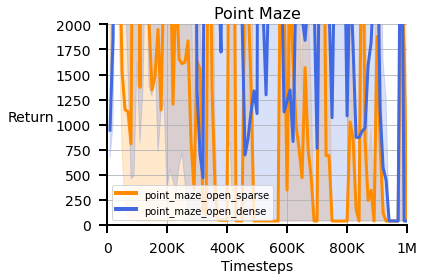

In [8]:
# plt.figure()
plt_formatter()
plt.xlim([0, 1000000])
plt.ylim([0, 2000])
# sns.lineplot(x="step", y='avg_ret', data=df[df['env']==env], hue='env', palette=color_palette)
print(color_palette)
# sns.lineplot(x="step", y='avg_ret', data=df[df['env'].str.contains('point_maze_T_dense')], hue='env', palette=color_palette)
sns.lineplot(x="step", y='steps_to_goal', data=df[df['env'].str.contains('open')], hue='env', palette=color_palette)
set_labels("Point Maze", labelpad=25)

# plt.legend(handles=legend_elements, loc='lower right')
plt.legend(handles=legend_elements, loc='best')
plt.tight_layout()
plt.locator_params(axis='x', nbins=8)
# plt.savefig(title+'.pdf', dpi=200)
plt.show()
plt.close()